In [ ]:
"""
Synthetic Detection Generator
"""

import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF

import PIL
from PIL import ImageDraw

torchvision.set_image_backend('accimage')

default_config = {
    'canvas': (200, 200),
    'margin': (50, 50),
    'stride': (10, 10),
    'min_size': 16,
    'max_size': 64,
    'keep_aspect': True,
    'rotation': 5,
    'bgd_contrast': 1.0,
    'bgd_bridgtness': 1.0,
    'fgd_contrast': 1.0,
    'fgd_bridgtness': 1.8,
    'blur_radius': 1.75
}

class DetectionDataset:
    """
    Params:
        data_src: torch image Dataset
        avg_num: float, mean number of objects per image
        max_iter: int
        poisson: bool, if True randomly sample the number of objects
        config: simulator config
    Output:
        image: Tensor of the image, shape (C, H, W)
        masks: Tensor, shape (N, H, W), location of boxes
        boxes: Tensor, shape (N, 4)
    """
    def __init__(self,
                 data_src,
                 avg_num,
                 max_iter=1000,
                 poisson=True,
                 config=default_config):

        self.max_iter = max_iter
        self.data = data_src
        self.poisson = poisson
        self.num = avg_num
        self.config = config

    def __getitem__(self, idx):

        num = np.random.poisson(self.num) if self.poisson else self.num
        num = max(1, num)
        img, box, lab = generate_detection_image(self.data, num, self.config)

        W, H = img.size

        msk = box_to_msk(box, (W, H))
        img = TF.to_tensor(img)

        # _norm = torch.tensor([W, H, W, H]).view(1, 4).float()

        box = torch.tensor(box).float()
        lab = torch.tensor(lab).long()

        return img, msk, box, lab

    def __repr__(self):
        return "Source:\n{},\nmax iter: {}, avg dets: {}, Poisson: {}".format(
            self.data, self.max_iter, self.num, self.poisson)

    def __len__(self):
        return self.max_iter

# number of objects per image varies
def collate_fn(batch):
    img_ = []
    msk_ = []
    box_ = []
    lab_ = []
    for tup in batch:
        img, msk, box, lab = tup
        if len(box) > 0:
            _, H, W = img.size()
            box[:, 0::2] /= W
            box[:, 1::2] /= H
        img_.append(img)
        msk_.append(msk)
        box_.append(box)
        lab_.append(lab)
    img_ = torch.stack(img_, dim=0)
    return img_, msk_, box_, lab_

def generate_detection_image(src_data,
                             num_src,
                             config=default_config):
    """
    params:
        src_data: torch Dataset class or List-like object [image, label]
        num_src:  number of images
        config:   simulator config

    output:
        image:  PIL Image
        boxes:  List[Box], Box is List[int] [x0, y0, x1, y1]
        labels: List[int], ground truth labels for each box
    """

    canvas = config['canvas']
    margin = config['margin']
    stride = config['stride']
    min_size = config['min_size']
    max_size = config['max_size']
    rotation = config['rotation']
    keep_aspect = config['keep_aspect']

    bgd = PIL.Image.fromarray(np.random.randint(100, 200, (5, 5, 3)).astype(np.uint8)).resize(canvas, 3)
    bgd = PIL.ImageEnhance.Contrast(bgd).enhance(config['bgd_contrast'])
    bgd = PIL.ImageEnhance.Brightness(bgd).enhance(config['bgd_bridgtness'])

    xrange_ = range(0, canvas[0]-margin[0], stride[0])
    yrange_ = range(0, canvas[1]-margin[1], stride[1])
    idx_ = np.random.choice(len(src_data), num_src)
    dx_ = np.random.choice(xrange_, num_src, replace=False)
    dy_ = np.random.choice(yrange_, num_src, replace=False)
    w_ = np.random.choice(range(min_size, max_size+1, 8), num_src)
    h_ = np.random.choice(range(min_size, max_size+1, 8), num_src) if not keep_aspect else w_
    rot_ = np.random.choice(range(-rotation, rotation), num_src)

    lab_ = []
    box_ = []
    img_ = []
    for jdx, idx in enumerate(idx_):

        img, lab = src_data[idx]

        img = img.resize((w_[jdx], h_[jdx]), resample=3)
        img = img.rotate(rot_[jdx], resample=3, expand=True)
        img_.append(img)

        box = list(img.getbbox())

        dx, dy = dx_[jdx], dy_[jdx]

        box[0::2] += dx
        box[1::2] += dy
        box[0] = clip(box[0], 0, canvas[0])
        box[2] = clip(box[2], 0, canvas[0])
        box[1] = clip(box[1], 0, canvas[1])
        box[3] = clip(box[3], 0, canvas[1])

        if (box[2] - box[0])*(box[3] - box[1]) > 0:
            lab_.append(lab)
            box_.append(box)
            color = np.random.randint(100, 200, (3,))
            fgd = PIL.ImageOps.colorize(img,
                                        black=color*0.7,
                                        white=color).convert('RGB')
            fgd = PIL.ImageEnhance.Contrast(fgd).enhance(config['fgd_contrast'])
            fgd = PIL.ImageEnhance.Brightness(fgd).enhance(config['fgd_bridgtness'])
            msk = img.filter(PIL.ImageFilter.GaussianBlur(radius=config['blur_radius']))
            bgd.paste(fgd, (dx, dy), msk)

    return bgd, box_, lab_

def clip(x, minval, maxval):
    if x < minval:
        return minval
    if x > maxval:
        return maxval
    return x

def box_to_msk(box, pil_size):
    """
    params:
        box: List[List[int]] list of boxes, each box is [x0, y0, x1, y1]
        pil_size: Tuple[int] (W, H)

    output:
        mask: Tensor shape (B, W, H)
    """
    W, H = pil_size
    box_ = torch.tensor(box).long()
    msk_ = torch.zeros(len(box_), H, W)
    for idx in range(len(box_)):
        b = box_[idx]
        msk_[idx, b[1]:b[3], b[0]:b[2]] += 1
    return msk_

In [ ]:
mnist = torchvision.datasets.MNIST('.', download=True, train=True)
fashion = torchvision.datasets.FashionMNIST('.', download=True, train=True)

In [ ]:
detdata = DetectionDataset(mnist, 2.5)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
item = detdata[0]

In [ ]:
np.random.randint(low=100, high=255, size=(10, 10, 3)).shape

(10, 10, 3)

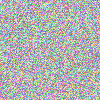

In [ ]:
PIL.Image.fromarray(np.random.randint(low=100, high=255, size=(100, 100, 3)).astype(np.uint8))

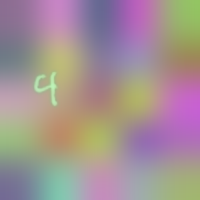

In [ ]:
TF.to_pil_image(item[0])

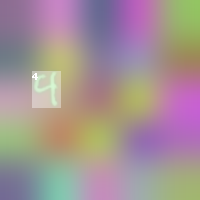

In [ ]:
TF.to_pil_image(torchvision.utils.draw_bounding_boxes(
    (item[0]*255).to(torch.uint8), 
    item[2], 
    labels=[str(x) for x in item[3].tolist()],
    fill=True
    ))

In [ ]:
?torchvision.utils.draw_bounding_boxes

In [ ]:
(item[0]*255).to(torch.uint8).shape

torch.Size([3, 200, 200])

In [ ]:
item[2]

tensor([[ 32.,  71.,  60., 107.]])

In [ ]:
from typing import *

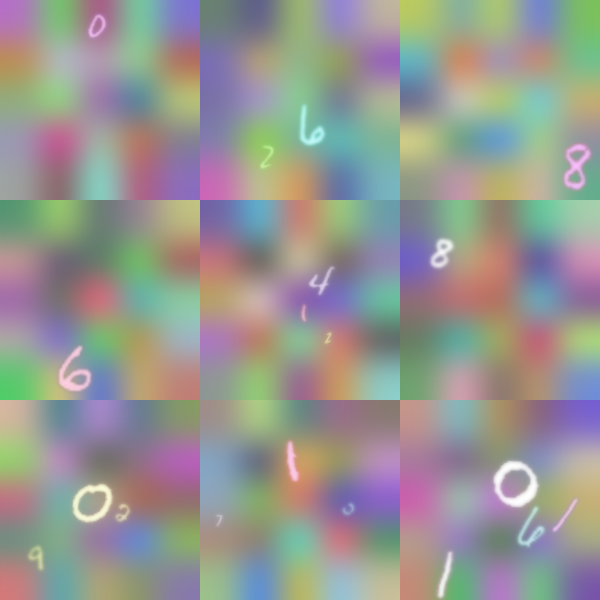

In [ ]:
def collage_pil_images(
    images: List[PIL.Image.Image], 
    rows: int, 
    columns: int, 
    atom_size: Optional[Tuple[int]]=None, 
    mode: str ='RGB'):

    if atom_size is None:
        atom_size = images[0].size
    
    w, h = atom_size
    
    assert rows * columns == len(images)

    W, H = w * columns, h * rows

    img = PIL.Image.new(mode, (W, H))
    idx = 0
    for rdx in range(rows):
        for cdx in range(columns):

            img.paste(images[idx], (w*cdx, h*rdx))
            idx += 1
    
    return img


collage_pil_images([TF.to_pil_image(detdata[idx][0]) for idx in range(3*3)], rows=3, columns=3)

In [ ]:
img_ = []
box_ = []
lab_ = []
for idx in range(3*3):
    img, _, box, lab = detdata[idx]
    img_.append(TF.to_pil_image(img))
    box_.append(box)
    lab_.append(lab)

In [ ]:
lab = torch.cat(lab_)
lab = [str(l) for l in lab.tolist()]

In [ ]:
def collage_boxes(
    boxes: List[torch.Tensor], 
    rows: int, 
    columns: int, 
    atom_size: Tuple[int]):
    
    idx = 0
    for rdx in range(rows):
        for cdx in range(columns):
            boxes[idx][:, 0::2] += cdx * atom_size[0]
            boxes[idx][:, 1::2] += rdx * atom_size[1]
            idx += 1
    
    return torch.cat(boxes)

In [ ]:
box = collage_boxes(box_, 3, 3, default_config['canvas'])

In [ ]:
img = collage_pil_images(img_, 3, 3, default_config['canvas'])

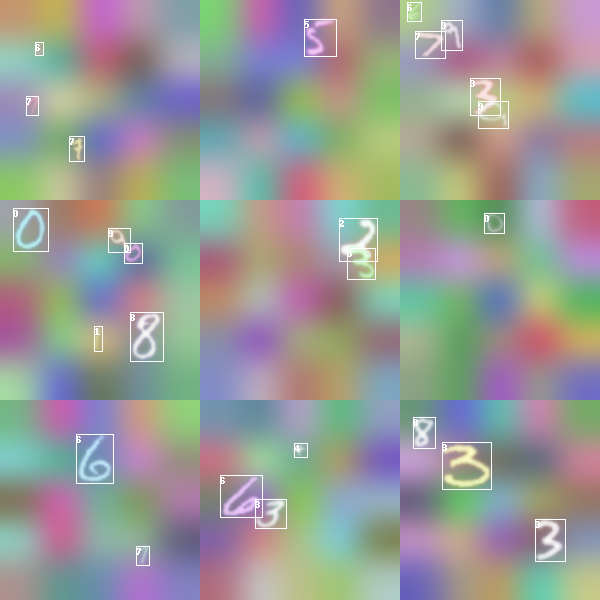

In [ ]:
TF.to_pil_image(torchvision.utils.draw_bounding_boxes(
    (TF.to_tensor(img)*255).to(torch.uint8), 
    box, 
    labels=lab,
    fill=False, width=1
    ))

In [ ]:
PIL.Image.fromarray(np.array(img))